# IKEA Parts Labelling with SAM + DINOv2 (M3 Pro friendly)

This notebook:

1. Loads an IKEA instruction page illustration.
2. Uses SAM to segment the parts and lets you assign human-readable labels.
3. Uses DINOv2 to create embeddings for each labelled part (reference vectors).
4. For a real-world photo of parts on the floor:
    - Segments it with SAM
    - Embeds each segment with DINOv2
    - Finds the nearest IKEA-part label per segment
5. Lets you highlight only the parts for a selected label on the photo.


In [5]:
%pip install --upgrade pip

# Torch CPU wheels (versions compatible with your cp313 / macOS arm64 setup)
%pip install --index-url https://download.pytorch.org/whl/cpu \
    "torch==2.9.1" "torchvision==0.24.1"

# Vision + feature extraction stack (includes DINOv2 via timm)
%pip install opencv-python pillow matplotlib einops timm

# SAM (v1) repo
%pip install git+https://github.com/facebookresearch/segment-anything.git

# NOTE: no dinov2 GitHub repo install here; use timm's DINOv2 models instead.


Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/r7/vdpmjwm55fl4_ys4dmdzv2jc0000gn/T/pip-req-build-tfi2k21_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/r7/vdpmjwm55fl4_ys4dmdzv2jc0000gn/T/pip-req-build-tfi2k21_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


General compute device: mps
SAM device: cpu


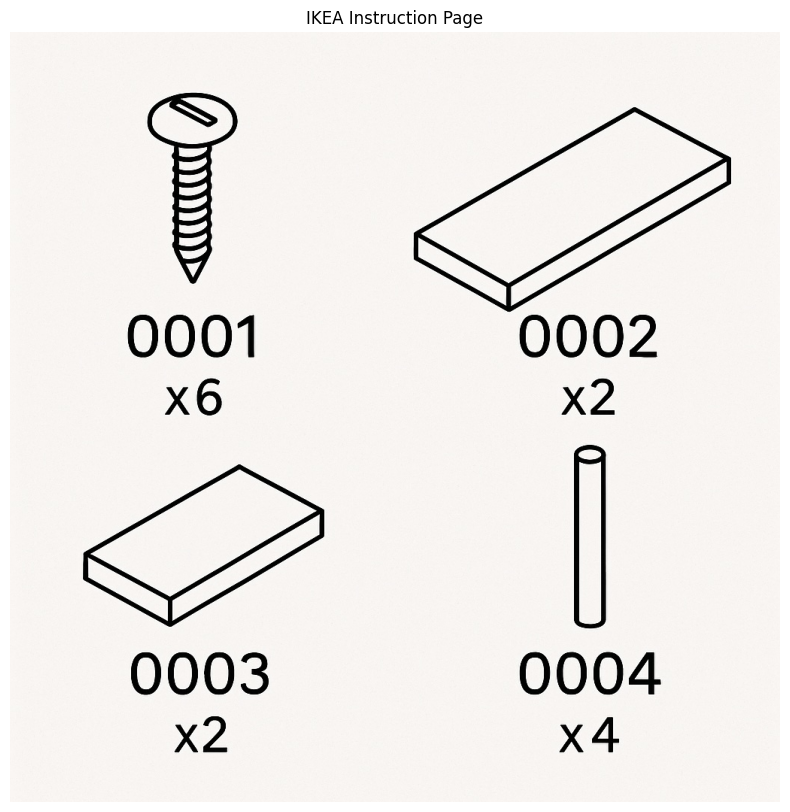

Generated 43 masks on IKEA page


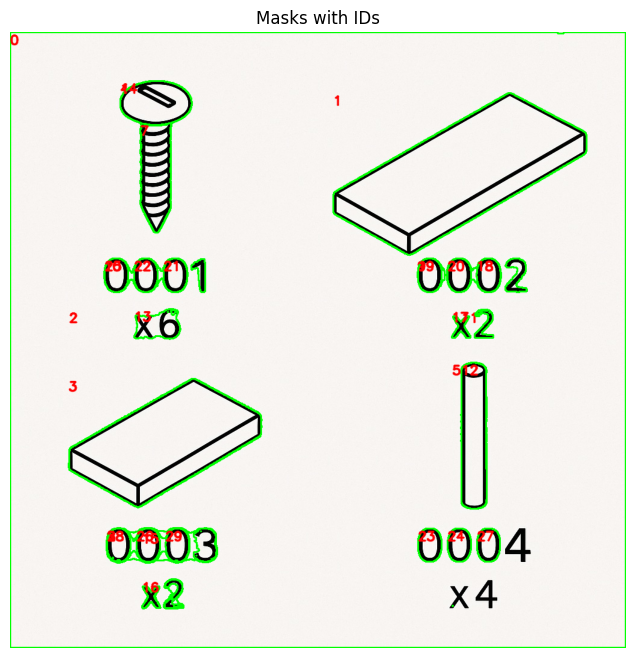

Defined IKEA part labels: {0: 'screw_a', 2: 'side', 5: 'shelf', 8: 'pole'}
Reference labels: ['screw_a', 'side', 'shelf', 'pole']


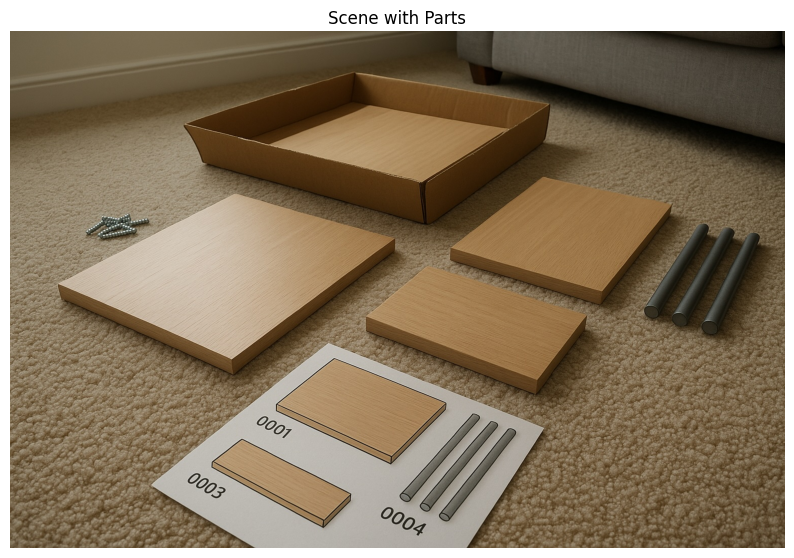

Generated 56 masks for scene


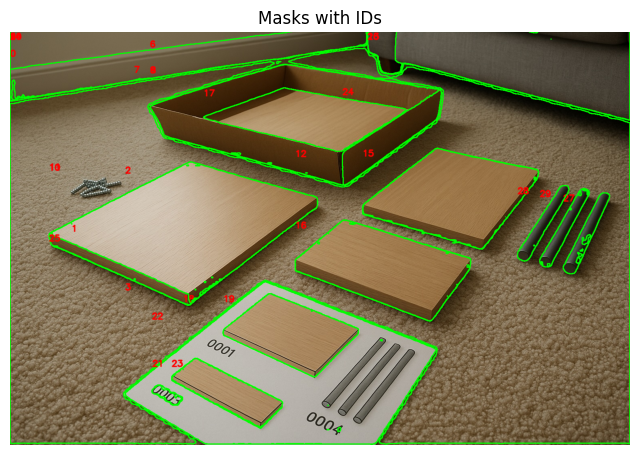

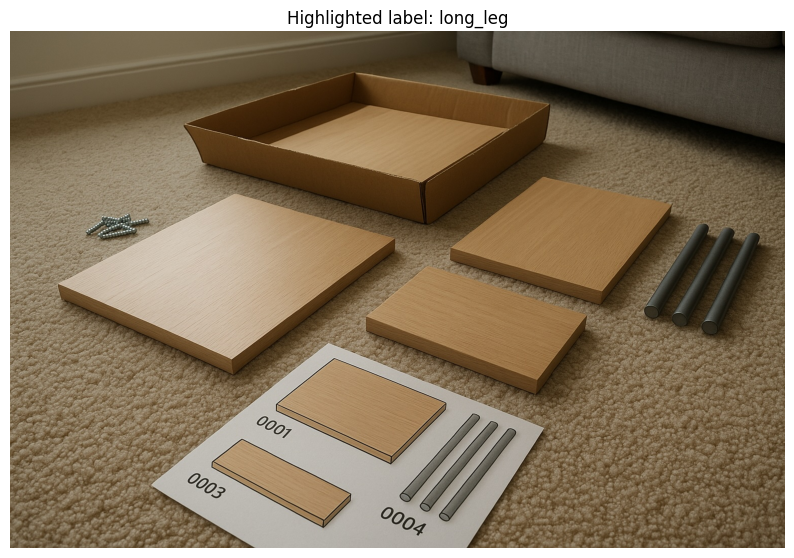

In [ ]:
# --- Imports -----------------------------------------------------------------

import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
from pathlib import Path
import urllib.request

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import timm
import torchvision.transforms as T
from sklearn.metrics.pairwise import cosine_similarity


# --- Device selection --------------------------------------------------------
# Prefer CUDA, then MPS (Apple GPU), else CPU for general compute (DINOv2, etc.)

if torch.cuda.is_available():
    compute_device = torch.device("cuda")
elif torch.backends.mps.is_available():
    compute_device = torch.device("mps")
else:
    compute_device = torch.device("cpu")

device = compute_device  # used for DINOv2 and other models

# For SAM specifically, avoid MPS float64 issues by forcing CPU when on MPS
if compute_device.type == "mps":
    sam_device = torch.device("cpu")
else:
    sam_device = compute_device

print(f"General compute device: {device}")
print(f"SAM device: {sam_device}")


# --- SAM model + mask generator ---------------------------------------------

SAM_MODEL_TYPE = "vit_h"
SAM_CHECKPOINT_NAME = "sam_vit_h_4b8939.pth"
SAM_CHECKPOINT_URL = (
    "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
)

CHECKPOINTS_DIR = Path("checkpoints")
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)

SAM_CHECKPOINT_PATH = CHECKPOINTS_DIR / SAM_CHECKPOINT_NAME

# Download checkpoint if it does not exist locally
if not SAM_CHECKPOINT_PATH.exists():
    print(f"Downloading SAM checkpoint to {SAM_CHECKPOINT_PATH} ...")
    urllib.request.urlretrieve(SAM_CHECKPOINT_URL, SAM_CHECKPOINT_PATH)
    print("Download complete.")

# Initialize SAM
sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=str(SAM_CHECKPOINT_PATH))
sam.to(device=sam_device)
sam.eval()

# Automatic mask generator
# You can tweak these parameters to control number/quality of masks and memory usage.
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,           # lower this to reduce masks/memory if needed
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)


# DINOv2 model + embedding function --------------------------------------

# DINOv2 small transformer (ViT-S/14) via timm
# "vit_small_patch14_dinov2.lvd142m" is a common DINOv2 config in timm.
dinov2_model = timm.create_model(
    "vit_small_patch14_dinov2.lvd142m",
    pretrained=True,
    num_classes=0,  # return embeddings instead of classification logits
)
dinov2_model.to(device)
dinov2_model.eval()

# DINOv2-specific preprocessing (ViT-S/14 expects 518x518 inputs)
DINOV2_IMAGE_SIZE = 518
dinov2_transform = T.Compose(
    [
        T.Resize((DINOV2_IMAGE_SIZE, DINOV2_IMAGE_SIZE)),
        T.ToTensor(),
        T.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ]
)



@torch.no_grad()
def get_dino_embedding(pil_image: Image.Image) -> np.ndarray:
    """
    Return a 1D NumPy embedding vector for a PIL image.

    Output shape: (1, D) and dtype float32, on CPU.
    """
    x = dinov2_transform(pil_image).unsqueeze(0).to(device=device, dtype=torch.float32)

    feats = dinov2_model(x)

    # Handle potential future variants of timm outputs (lists/tuples/dicts)
    if isinstance(feats, (list, tuple)):
        feats = feats[0]
    elif isinstance(feats, dict):
        # Try some common DINOv2 feature keys, then fall back to first value
        for key in ("x_norm_clstoken", "x_norm_clstoken_mlp", "feat", "features"):
            if key in feats:
                feats = feats[key]
                break
        else:
            feats = next(iter(feats.values()))

    emb = feats.detach().cpu().numpy().reshape(1, -1).astype("float32")
    return emb


# --- Basic image utilities ---------------------------------------------------

def load_image(path: str) -> np.ndarray:
    """Load an image from disk as an RGB NumPy array."""
    img = Image.open(path).convert("RGB")
    return np.array(img)


def show_image(img: np.ndarray, title: str | None = None, size=(8, 8)) -> None:
    """Display a NumPy RGB image with optional title."""
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# --- SAM-based mask utilities -----------------------------------------------

def generate_masks(image_np: np.ndarray):
    """
    Run SAM mask generator on a NumPy RGB image.

    Returns list of dicts with keys like 'segmentation', 'bbox', 'area', etc.
    """
    masks = mask_generator.generate(image_np)
    # Sort masks by area (descending) for easier manual inspection
    masks = sorted(masks, key=lambda x: x["area"], reverse=True)
    return masks


def overlay_masks_with_ids(image_np: np.ndarray, masks, max_masks: int = 20) -> None:
    """
    Show masks as colored contours with ID numbers.

    IDs are simply the index in the masks list (0..N-1).
    """
    img_bgr = cv2.cvtColor(image_np.copy(), cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX

    for idx, m in enumerate(masks[:max_masks]):
        seg = m["segmentation"].astype(np.uint8)
        contours, _ = cv2.findContours(
            seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        color = (0, 255, 0)
        cv2.drawContours(img_bgr, contours, -1, color, 2)

        # Put ID label near mask's bounding box
        x, y, bw, bh = m["bbox"]
        cv2.putText(
            img_bgr,
            str(idx),
            (int(x), int(y) + 20),
            font,
            0.7,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    show_image(img_rgb, title="Masks with IDs")


def crop_mask_region(image_np: np.ndarray, mask) -> Image.Image:
    """
    Crop the masked region as a tight bounding box from the image.

    Returns a PIL.Image where pixels outside the mask are set to black.
    """
    seg = mask["segmentation"]
    x, y, w_box, h_box = mask["bbox"]
    x, y, w_box, h_box = int(x), int(y), int(w_box), int(h_box)

    cropped = image_np[y : y + h_box, x : x + w_box]
    seg_cropped = seg[y : y + h_box, x : x + w_box]

    # Apply mask to keep background clean
    masked = deepcopy(cropped)
    masked[seg_cropped == 0] = 0

    return Image.fromarray(masked)


# --- 1. IKEA instruction page: segment + label parts ------------------------

IKEAPAGE_PATH = "../sample_data/ikea_fake.jpg"  # TODO: set to your actual file path

ikea_img = load_image(IKEAPAGE_PATH)
show_image(ikea_img, "IKEA Instruction Page", size=(10, 10))

# This call previously failed on MPS; now it uses CPU for SAM, so it should be safe.
ikea_masks = generate_masks(ikea_img)
print(f"Generated {len(ikea_masks)} masks on IKEA page")

overlay_masks_with_ids(ikea_img, ikea_masks, max_masks=30)

# Example mapping from mask index -> human-readable label
# Adjust these indices after inspecting the overlay.
IKEAPART_LABELS = {
    
    2: "side",
    4: "screw",
    5: "shelf",
    8: "pole",
    # ... add your own indices/labels based on the overlay
}
print("Defined IKEA part labels:", IKEAPART_LABELS)


# --- 2. Build reference embeddings per IKEA part label ----------------------

label_to_embeddings: dict[str, list[np.ndarray]] = {}

for mask_idx, label in IKEAPART_LABELS.items():
    mask = ikea_masks[mask_idx]
    part_crop = crop_mask_region(ikea_img, mask)
    emb = get_dino_embedding(part_crop)  # shape (1, D), float32

    if label not in label_to_embeddings:
        label_to_embeddings[label] = []
    label_to_embeddings[label].append(emb)

# Average embeddings for each label -> single reference vector
label_to_ref_emb: dict[str, np.ndarray] = {}

for label, embs in label_to_embeddings.items():
    stacked = np.vstack(embs)             # (N, D)
    mean_emb = stacked.mean(axis=0, keepdims=True)  # (1, D)
    label_to_ref_emb[label] = mean_emb.astype("float32")

print("Reference labels:", list(label_to_ref_emb.keys()))


# --- 3. Real-world scene: segment + classify each segment -------------------

SCENE_PATH = "../sample_data/ikea_floor.jpg"  # TODO: set to your actual file path

scene_img = load_image(SCENE_PATH)
show_image(scene_img, "Scene with Parts", size=(10, 10))

scene_masks = generate_masks(scene_img)
print(f"Generated {len(scene_masks)} masks for scene")

overlay_masks_with_ids(scene_img, scene_masks, max_masks=30)

# Prepare reference matrix & label list for cosine similarity
ref_labels = list(label_to_ref_emb.keys())
ref_matrix = np.vstack([label_to_ref_emb[l] for l in ref_labels]).astype("float32")  # (L, D)


def classify_mask_with_dino(
    mask,
    image_np: np.ndarray,
    ref_matrix: np.ndarray,
    ref_labels: list[str],
    min_sim_threshold: float = 0.3,
):
    """
    Return (best_label, best_similarity) for a given mask & image.

    If best similarity is below min_sim_threshold, returns (None, best_similarity).
    """
    crop = crop_mask_region(image_np, mask)
    emb = get_dino_embedding(crop)  # (1, D) float32

    sims = cosine_similarity(emb, ref_matrix)[0]  # (L,)
    best_idx = int(np.argmax(sims))
    best_sim = float(sims[best_idx])
    best_label = ref_labels[best_idx]

    if best_sim < min_sim_threshold:
        return None, best_sim
    return best_label, best_sim


# Classify each scene mask
scene_mask_labels = []  # list of dict {mask_idx, label, similarity}

for idx, m in enumerate(scene_masks):
    label, sim = classify_mask_with_dino(
        m, scene_img, ref_matrix, ref_labels, min_sim_threshold=0.3
    )
    scene_mask_labels.append(
        {
            "mask_idx": idx,
            "label": label,
            "similarity": sim,
        }
    )

# Quick peek at the first few classification results
scene_mask_labels[:10]


# --- 4. Visualization: highlight all masks for a given label ----------------

def highlight_label_in_scene(
    scene_image_np: np.ndarray,
    scene_masks,
    scene_mask_labels,
    target_label: str,
    outline_thickness: int = 3,
) -> None:
    """
    Draw contours and labels only for masks classified with target_label.
    """
    img_bgr = cv2.cvtColor(scene_image_np.copy(), cv2.COLOR_RGB2BGR)
    font = cv2.FONT_HERSHEY_SIMPLEX

    for meta in scene_mask_labels:
        if meta["label"] != target_label:
            continue

        mask_idx = meta["mask_idx"]
        m = scene_masks[mask_idx]
        seg = m["segmentation"].astype(np.uint8)

        contours, _ = cv2.findContours(
            seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Draw green contours; change color per label if desired
        cv2.drawContours(img_bgr, contours, -1, (0, 255, 0), outline_thickness)

        x, y, w_box, h_box = m["bbox"]
        text = f"{target_label}"
        cv2.putText(
            img_bgr,
            text,
            (int(x), int(y) + 20),
            font,
            0.7,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    show_image(img_rgb, f"Highlighted label: {target_label}", size=(10, 10))


# Example: highlight only "long_leg" parts
target_label = "screw"  # change to any label from label_to_ref_emb.keys()
highlight_label_in_scene(
    scene_image_np=scene_img,
    scene_masks=scene_masks,
    scene_mask_labels=scene_mask_labels,
    target_label=target_label,
)
